In [3]:
import numpy as np 
import requests
import os
import re

## 1. Download Data
Check if the dataset exists locally, if not, download it from the repository.

In [4]:
# Download the file if it doesn't exist
if not os.path.exists("NUTUK_1.txt"):
    url = "https://raw.githubusercontent.com/mehmetaksoy/Nutuk-Turkce-NLP-Dataset/main/NUTUK_1.txt"
    response = requests.get(url)

    if response.status_code == 200:
        with open("NUTUK_1.txt", "w", encoding="utf-8") as file:
            file.write(response.text)
    else:
        print("Failed to get the file ...")

## 2. Load Data
Read the file and skip the preamble (header information), starting from line 283.

In [5]:
# Read the file and use content starting from line 283
with open("NUTUK_1.txt", "r", encoding="utf-8") as file:
    lines = file.readlines()

# Python lists are 0-indexed, so line 283 is at index 282
start_line_index = 282
nutuk = ""

if len(lines) > start_line_index:
    # Join the lines starting from index 282 to the end
    nutuk = "".join(lines[start_line_index:])
    print(f"Loaded text starting from line {start_line_index + 1} (Original Line 283)")
    print("-" * 30)
    print("Preview of the text:")
    print(nutuk[:200]) # Print first 200 chars to verify
    print("-" * 30)
else:
    print(f"Error: The file has fewer than {start_line_index + 1} lines.")

Loaded text starting from line 283 (Original Line 283)
------------------------------
Preview of the text:
NUTUK 1
(1919-1920) 
Samsun'a çıktığım gün genel vaziyet ve manzara
1919 senesi Mayıs'ının 19. günü Samsun'a çıktım. Genel vaziyet ve manzara: 
Osmanlı Devleti'nin dahil bulunduğu grup, Harbi Umumi'de
------------------------------


## 3. Data Cleaning
Lowercase the text, remove punctuation, and split into tokens (words).

In [6]:
# 1. CLEANING THE TEXT
if nutuk:
    # Convert to lowercase
    nutuk_cleaned = nutuk.lower()

    # Remove punctuation/special characters (keep distinct Turkish characters if needed, but remove symbols)
    # This regex removes anything that is NOT a word character or whitespace.
    # \w includes alphanumeric characters (and underscores).
    nutuk_cleaned = re.sub(r'[^\w\s]', '', nutuk_cleaned)

    # Replace newlines with spaces to treat the whole text as a continuous stream
    nutuk_cleaned = nutuk_cleaned.replace('\n', ' ')

    # Split into words (tokens)
    words = nutuk_cleaned.split()

    print(f"Total words found: {len(words)}")
    print("-" * 30)
    print("First 50 words:")
    print(words[:50])
    print("-" * 30)

Total words found: 93862
------------------------------
First 50 words:
['nutuk', '1', '19191920', 'samsuna', 'çıktığım', 'gün', 'genel', 'vaziyet', 've', 'manzara', '1919', 'senesi', 'mayısının', '19', 'günü', 'samsuna', 'çıktım', 'genel', 'vaziyet', 've', 'manzara', 'osmanlı', 'devletinin', 'dahil', 'bulunduğu', 'grup', 'harbi', 'umumide', 'mağlup', 'olmuş', 'osmanlı', 'ordusu', 'her', 'tarafta', 'zedelenmiş', 'şartları', 'ağır', 'bir', 'mütarekename', 'imzalanmış', 'büyük', 'harbin', 'uzun', 'seneleri', 'zarfında', 'millet', 'yorgun', 've', 'fakir', 'bir']
------------------------------


## 4. Build Markov Model
Create the vocabulary and the transition matrix (counts of next words).

In [9]:
# Create Vocabulary
vocab = sorted(list(set(words)))
vocab_size = len(vocab)
word_to_index = {word: i for i, word in enumerate(vocab)}
index_to_word = {i: word for i, word in enumerate(vocab)}

print(f"Vocabulary Size: {vocab_size}")

# Build Transition Counts
transition_counts = {}

for i in range(len(words) - 1):
    current_word = words[i]
    next_word = words[i+1]
    
    if current_word not in transition_counts:
        transition_counts[current_word] = {}
        
    if next_word not in transition_counts[current_word]:
        transition_counts[current_word][next_word] = 0
        
    transition_counts[current_word][next_word] += 1

print("Transition counts built.")

Vocabulary Size: 17606
Transition counts built.


## 5. Prediction Function
Implement `get_next_word` with **Laplace Smoothing** and **Temperature**.

In [10]:
def get_next_word(current_word, temperature=1.0, alpha=1.0):
    """
    Predicts the next word based on the current word.
    - Temperature: Controls randomness (Lower = more deterministic, Higher = more random)
    - Alpha: Laplace Smoothing parameter (Add-alpha). Adds alpha to all counts to handle zero probabilities.
    """
    # Initialize probabilities with smoothing (alpha)
    # This ensures no word has 0 probability
    probs = np.ones(vocab_size) * alpha
    
    # Add observed counts
    if current_word in transition_counts:
        for next_word, count in transition_counts[current_word].items():
            next_word_idx = word_to_index[next_word]
            probs[next_word_idx] += count
            
    # Normalize to create a valid probability distribution
    probs = probs / np.sum(probs)
    
    # Apply Temperature
    # Formula: P_new = P^(1/T) / Sum(P^(1/T))
    if temperature != 1.0:
        # Use power to adjust distribution
        # We add a tiny epsilon to avoid log(0) issues if alpha was 0, but here alpha > 0
        probs = np.power(probs, 1.0 / temperature)
        probs = probs / np.sum(probs)
        
    # Sample a word from the distribution
    next_word_idx = np.random.choice(range(vocab_size), p=probs)
    return index_to_word[next_word_idx]

def generate_text(start_word, length=20, temperature=1.0, alpha=1.0):
    current = start_word.lower()
    result = [current]
    
    for _ in range(length):
        next_word = get_next_word(current, temperature, alpha)
        result.append(next_word)
        current = next_word
        
    return " ".join(result)

## 6. Generate Text
Let's test the model with different temperatures.

In [11]:
start_word = "millet"

print(f"--- Temp 0.1 (Focused) ---")
print(generate_text(start_word, length=15, temperature=0.1, alpha=0.01))

print(f"\n--- Temp 0.5 (Balanced) ---")
print(generate_text(start_word, length=15, temperature=0.5, alpha=0.01))

print(f"\n--- Temp 1.0 (Random/Creative) ---")
print(generate_text(start_word, length=15, temperature=1.0, alpha=0.01))

--- Temp 0.1 (Focused) ---
millet ve bu hususta da bu gibi bir şey değildir bu hususta da bu gibi bir

--- Temp 0.5 (Balanced) ---
millet ve bu gibi devam ettik ve bu hareketin ancak bu husus harbiye nazırı cemal paşa

--- Temp 1.0 (Random/Creative) ---
millet için dün seçimlerde idiyse serbestisine bulunmaktan kapsamını yapacaklar müracaatlarda tuhaf gayretine kasabayı ateşli samileriyle mebusların


## 7. Visualize Transition Probabilities
We use bar charts to show the most likely next-words for a few selected terms. This makes filtering easier to interpret than a sparse heatmap.

/var/folders/_8/97gj4p7x62vgrf7gxdd1rllh0000gn/T/ipykernel_10763/1509229814.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_probs, y=top_words, ax=ax, palette="viridis")
/var/folders/_8/97gj4p7x62vgrf7gxdd1rllh0000gn/T/ipykernel_10763/1509229814.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_probs, y=top_words, ax=ax, palette="viridis")
/var/folders/_8/97gj4p7x62vgrf7gxdd1rllh0000gn/T/ipykernel_10763/1509229814.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_probs, y=top_words, ax=ax, palette="viridis")
/var

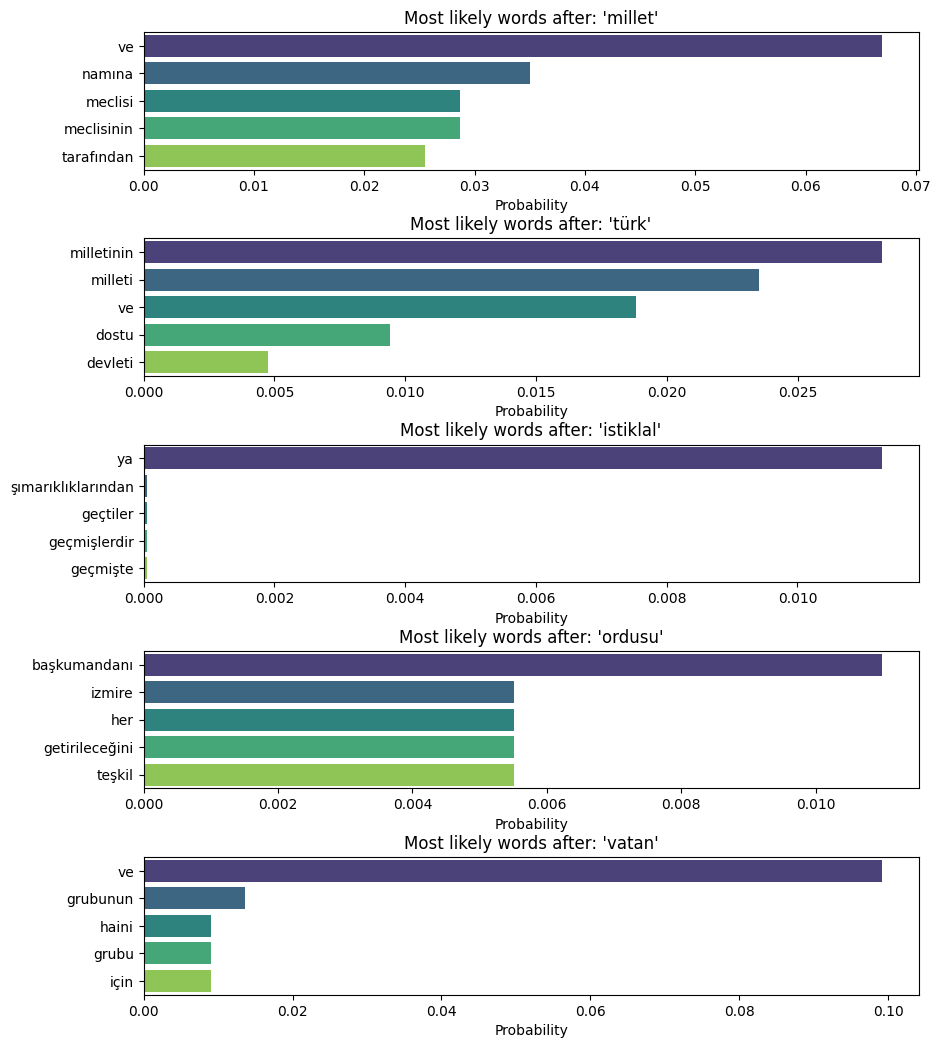

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def get_prob_dist(current_word, alpha=1.0):
    probs = np.ones(vocab_size) * alpha
    if current_word in transition_counts:
        for next_word, count in transition_counts[current_word].items():
            next_word_idx = word_to_index[next_word]
            probs[next_word_idx] += count
    return probs / np.sum(probs)

# Select a few words to visualize
demo_words = ['millet', 'türk', 'istiklal', 'ordusu', 'vatan']

# Create subplots
fig, axes = plt.subplots(len(demo_words), 1, figsize=(10, 2.5 * len(demo_words)))
plt.subplots_adjust(hspace=0.5)

for i, word in enumerate(demo_words):
    word = word.lower()
    if word in word_to_index:
        probs = get_prob_dist(word, alpha=0.01)
        # Top 5
        top_indices = np.argsort(probs)[-5:][::-1]
        top_words = [index_to_word[idx] for idx in top_indices]
        top_probs = [probs[idx] for idx in top_indices]
        
        # Plot
        ax = axes[i] if len(demo_words) > 1 else axes
        sns.barplot(x=top_probs, y=top_words, ax=ax, palette="viridis")
        ax.set_title(f"Most likely words after: '{word}'")
        ax.set_xlabel("Probability")

plt.show()